In [1]:
# PARAMS

NORMALIZE_STATE = True
NORMALIZE_ACTIONS = True

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

sys.path.append('D:/projects/carball')

from tqdm.notebook import tqdm

import carball
from carball.controls.controls import ControlsCreator
from carball.json_parser import Game

# NN 
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cpu")

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
#print (plt.rcParams.keys())

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Parse the game from a .replay file

In [5]:
def replayToGame(replayID):
    replayPath = os.path.join("replays", "%s.replay" % replayID)
    print ("Loading...\n\t%s" % replayPath)
    json = carball.decompile_replay(replayPath)
    game = Game()
    game.initialize(loaded_json=json)
    return game

GAME = replayToGame("E8C22AC24D07E625140400958683F7A4")
# Parses action-related properties into their actual actions
ControlsCreator().get_controls(GAME)

Loading...
	replays\E8C22AC24D07E625140400958683F7A4.replay


D:/projects/carball\carball\controls\rotations.py:87: RuntimeWarning: invalid value encountered in sign
  rhs[1] / (T_p + np.sign(rhs[1]) * omega[1] * D_p),
D:/projects/carball\carball\controls\rotations.py:88: RuntimeWarning: invalid value encountered in sign
  rhs[2] / (T_y - np.sign(rhs[2]) * omega[2] * D_y)


In [6]:
nPlayers = len(GAME.players)
assert nPlayers == 6, "Only 3v3 modes supported, this has %d players" % nPlayers
print ("%d players loaded!" % nPlayers)

orangeIdx = [i for i, p in enumerate(GAME.players) if p.is_orange]
blueIdx = [i for i, p in enumerate(GAME.players) if not p.is_orange]

print ("\nOrange team:")
for i in orangeIdx:
    print ("\t%s" % GAME.players[i].name)
print ("\nBlue team:")
for i in blueIdx:
    print ("\t%s" % GAME.players[i].name)
        
nTimepoints = len(GAME.ball)
for p in GAME.players:
    assert len(p.data) == nTimepoints, "Players need the same number of time points, no leaves allowed"
print ("\n%d data points acquired" % nTimepoints)

6 players loaded!

Orange team:
	ThatOneDude
	Mixer
	padster

Blue team:
	nox
	StrigiL
	TheCliptree

6710 data points acquired


In [7]:
print ("Player values recorded:")
for pp in list(GAME.players[0].data):
    print (" * " + pp)
    
print ("\nBall values recorded:")
for bp in list(GAME.ball):
    print (" * " + bp)

Player values recorded:
 * ping
 * pos_x
 * pos_y
 * pos_z
 * rot_x
 * rot_y
 * rot_z
 * vel_x
 * vel_y
 * vel_z
 * ang_vel_x
 * ang_vel_y
 * ang_vel_z
 * throttle
 * steer
 * handbrake
 * ball_cam
 * dodge_active
 * boost
 * boost_active
 * jump_active
 * double_jump_active
 * boost_collect

Ball values recorded:
 * pos_x
 * pos_y
 * pos_z
 * rot_x
 * rot_y
 * rot_z
 * vel_x
 * vel_y
 * vel_z
 * ang_vel_x
 * ang_vel_y
 * ang_vel_z
 * hit_team_no


In [8]:
PLAYER_STATE_KEYS = (
    ['pos_x', 'pos_y', 'pos_z'] +              # x \
    ['vel_x', 'vel_y', 'vel_z'] +              # dx/xt \
    ['rot_x', 'rot_y', 'rot_z'] +              # q \
    ['ang_vel_x', 'ang_vel_y', 'ang_vel_z'] +  # dq/dt \
    ['boost']
)

PLAYER_ACTION_KEYS = (
    ['throttle', 'steer', 'jump', 'boost', 'handbrake']
    #['throttle', 'steer', 'handbrake', 'jump_active', 'double_jump_active', 'boost_active', 'dodge_active']
)

# Only useful state for ball is (x,y,z) position
BALL_STATE_KEYS = (
    ['pos_x', 'pos_y', 'pos_z']
)

def normMiddlePeak(v):
    return 4/(1 + np.exp(-v)) - 2
    #return np.cbrt(v)
    #return math.erf(v)
    
def ensure01(values):
    assert np.sum(values.isin([0, 1])) == len(values), "Boolean column is not just 0s and 1s"
    return values
    

def imputePlayerState(stateDF):
    # Note: Missing values come from start of game or after explosion, in which case, 
    # should be an okay approximation to impute by forward then backfilling.
    return stateDF.fillna(method='ffill').fillna(method='bfill')

def normPlayerState(stateDF):
    normedDF = pd.DataFrame()
    normedDF['pos_x'] = stateDF['pos_x'] / 4000.0
    normedDF['pos_y'] = stateDF['pos_y'] / 5500.0
    normedDF['pos_z'] = stateDF['pos_z'] / 2000.0
    normedDF['vel_x'] = normMiddlePeak(stateDF['vel_x'] / 22000.0)
    normedDF['vel_y'] = normMiddlePeak(stateDF['vel_y'] / 22000.0)
    normedDF['vel_z'] = normMiddlePeak(normMiddlePeak(stateDF['vel_z'] / 16000.0))
    normedDF['rot_x'] = normMiddlePeak(stateDF['rot_x'] / (np.pi / 2))
    normedDF['rot_y'] = stateDF['rot_y'] / np.pi
    normedDF['rot_z'] = normMiddlePeak(stateDF['rot_z'] / np.pi)
    normedDF['ang_vel_x'] = stateDF['ang_vel_x'] / 6000.0
    normedDF['ang_vel_y'] = stateDF['ang_vel_y'] / 6000.0
    normedDF['ang_vel_z'] = stateDF['ang_vel_z'] / 6000.0
    normedDF['boost'] = stateDF['boost'] / 256.0
    assert normedDF.shape[1] == stateDF.shape[1], "Columns are missing normalization"
    return normedDF

def imputePlayerActions(actionDF):
    # Missing value here are converted to inaction
    actionDF = actionDF.fillna({
        'throttle': 0,
        'steer': 0,
        'jump': False,
        'boost': False,
        'handbrake': False,
    })
    actionDF = actionDF.astype({
        'jump': 'float64',               # from bool
        'boost': 'float64',              # from bool
        'handbrake': 'float64',          # from bool
    })
    return actionDF

def normPlayerActions(actionDF):
    # Note: ControlsCreator already norms them for us
    normedDF = actionDF.copy()
    assert normedDF.shape[1] == actionDF.shape[1], "Columns are missing normalization"
    return normedDF

def normBallState(stateDF):
    normedDF = pd.DataFrame()
    normedDF['pos_x'] = stateDF['pos_x'] / 4000.0
    normedDF['pos_y'] = stateDF['pos_y'] / 5500.0
    normedDF['pos_z'] = stateDF['pos_z'] / 2000.0
    assert normedDF.shape[1] == stateDF.shape[1], "Columns are missing normalization"
    return normedDF

def cleanPlayerStates(playerDF):
    stateDF = playerDF[PLAYER_STATE_KEYS]
    stateDF = imputePlayerState(stateDF)
    if NORMALIZE_STATE:
        stateDF = normPlayerState(stateDF)
    return stateDF

def cleanPlayerActions(controlDF):
    actionDF = controlDF[PLAYER_ACTION_KEYS]
    actionDF = imputePlayerActions(actionDF)
    if NORMALIZE_ACTIONS:
        actionDF = normPlayerActions(actionDF)
    return actionDF

def cleanBallStates(ballDF):
    stateDF = ballDF[BALL_STATE_KEYS] * 1.0 # force int -> float
    if NORMALIZE_STATE:
        stateDF = normBallState(stateDF)
    return stateDF
    
playerStates, playerActions = [], []
for p in tqdm(GAME.players):
    playerStates.append( cleanPlayerStates( p.data))
    playerActions.append(cleanPlayerActions(p.controls))
ballStates = cleanBallStates(GAME.ball)

## Distrubutions of values

Histogram for the distribution of values of each state and columns

Player states:


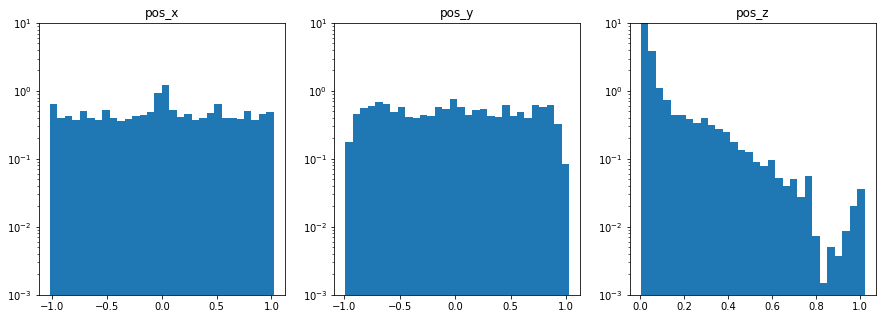

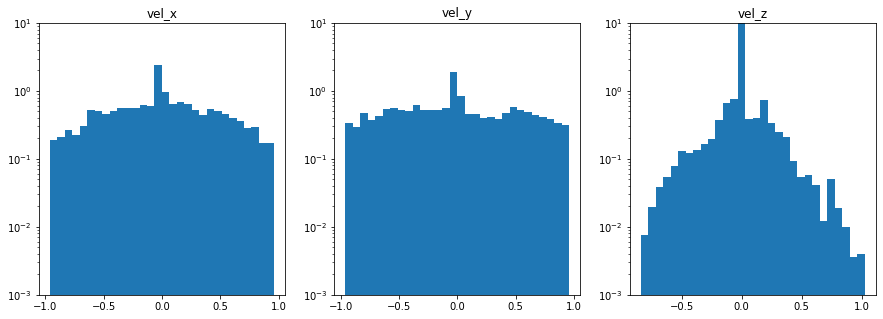

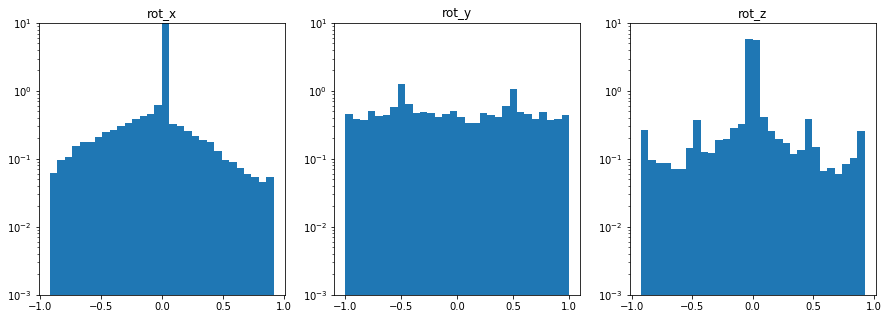

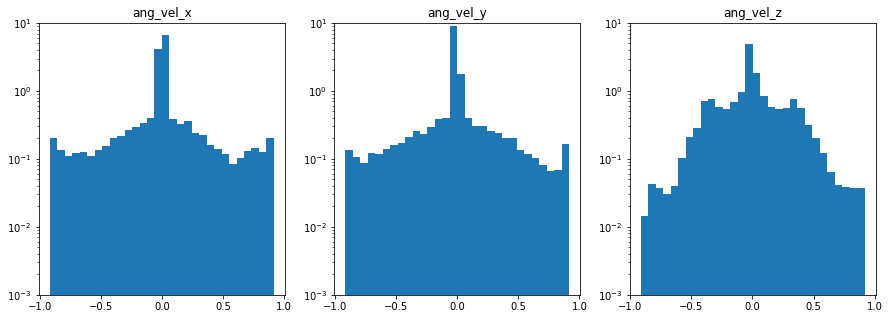

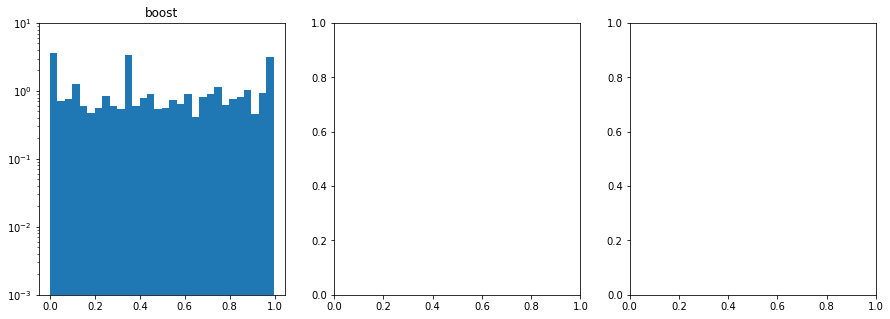

Player actions:


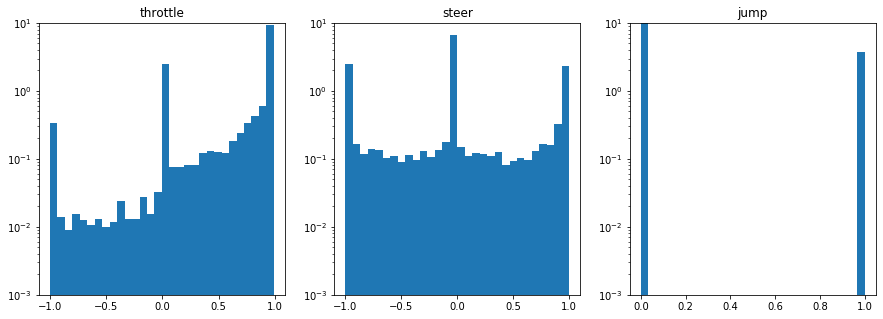

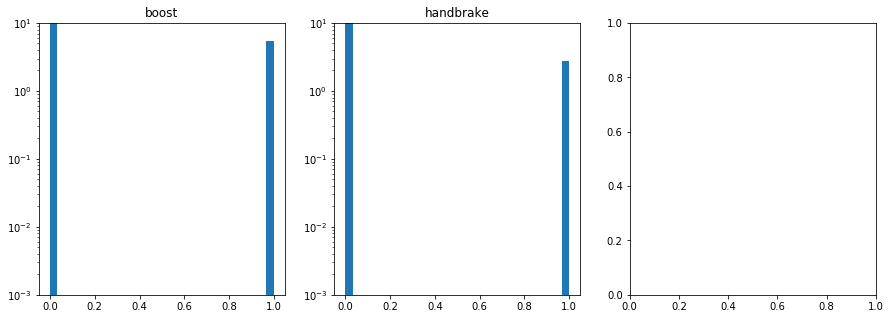

Ball states:


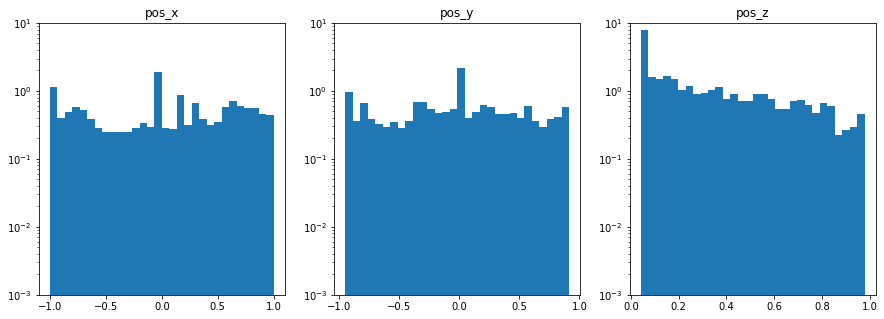

In [9]:
print ("Player states:")
for i in range(0, len(PLAYER_STATE_KEYS), 3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j in range(3):
        if i + j >= len(PLAYER_STATE_KEYS):
            break
        key = PLAYER_STATE_KEYS[i + j]
        allValues = []
        for pState in playerStates:
            allValues.extend(pState[key].values)
        ax[j].hist(allValues, log=True, bins=30, density=True)
        ax[j].set_title(key)
        ax[j].set_ylim((1e-3, 10))
    plt.show()

print ("Player actions:")
for i in range(0, len(PLAYER_ACTION_KEYS), 3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j in range(3):
        if i + j >= len(PLAYER_ACTION_KEYS):
            break
        key = PLAYER_ACTION_KEYS[i + j]
        allValues = []
        for pAct in playerActions:
            allValues.extend(pAct[key].values)
        ax[j].hist(allValues, log=True, bins=30, density=True)
        ax[j].set_title(key)
        ax[j].set_ylim((1e-3, 10))
    plt.show()
    
print ("Ball states:")
for i in range(0, len(BALL_STATE_KEYS), 3):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for j in range(3):
        if i + j >= len(BALL_STATE_KEYS):
            break
        key = BALL_STATE_KEYS[i + j]
        allValues = ballStates[key].values
        ax[j].hist(allValues, log=True, bins=30, density=True)
        ax[j].set_title(key)
        ax[j].set_ylim((1e-3, 10))
    plt.show()

In [10]:
###

In [11]:
def copyIntoPrefixed(toDF, fromDF, prefix):
    for column in list(fromDF):
        toDF[prefix + column] = fromDF[column]

def teamBreakdown(playerIdx):
    isOrange = GAME.players[playerIdx].is_orange
    teamIdx = [i for i in range(nPlayers) if i != playerIdx and GAME.players[i].is_orange == isOrange]
    enemyIdx = blueIdx if isOrange else orangeIdx
    return teamIdx, enemyIdx 
    
def stateAndActionsForPlayer(playerIdx):
    stateDF = pd.DataFrame(index=ballStates.index)
    copyIntoPrefixed(stateDF, ballStates, "b_")
    copyIntoPrefixed(stateDF, playerStates[playerIdx], "me_")
    
    teamIdx, enemyIdx = teamBreakdown(playerIdx)
    for i, idx in enumerate(teamIdx):
        copyIntoPrefixed(stateDF, playerStates[idx], "t%d_" % i)
    for i, idx in enumerate(enemyIdx):
        copyIntoPrefixed(stateDF, playerStates[idx], "e%d_" % i)
    assert max(stateDF.isna().sum()) == 0, "NA state values not successfully removed?"
    
    actionDF = playerActions[playerIdx]
    assert max(stateDF.isna().sum()) == 0, "NA action values not successfully removed?"
    return stateDF, actionDF
    
P2S, P2A = stateAndActionsForPlayer(2)
print (P2S.values.shape, P2S.values.dtype)
print (P2A.values.shape, P2A.values.dtype)

(6710, 81) float64
(6710, 5) float64


In [12]:
class MyModel(nn.Module):
    def __init__(self, state_size, action_size):
        super(MyModel, self).__init__()
        
        # Start with a super simple multi-layer perceptron, one hidden layer 
        self.dimH   = 10 # hidden layer has 10 dimensions
        self.dimIn  = state_size
        self.dimOut = action_size
 
        self.model = torch.nn.Sequential(
            nn.Linear(self.dimIn, self.dimH),
            nn.ReLU(),
            nn.Linear(self.dimH, self.dimOut),
        )
        self.model.to(device)

    def forward(self, x):
        # input data type needs to be converted to float
        return self.model(x.float())

    def select_action(self, state):
        self.eval()
        x = self.forward(state)
        self.train()
        return x.argmax().view(1, 1)


In [15]:
TOTAL_EPOCHS = 40
BATCH_SZ = 100
#PRINT_INTERVAL = 1000
LOG_INTERVAL = 1000
LEARNING_RATE = 0.0001
REGULARIZER_WEIGHT = 3e-4

writer = SummaryWriter()

def train_behavioral_cloning(dataBatches, model):
    # Adam optimizer usually a good default.
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZER_WEIGHT)
    
    # Decision is binary 0 or 1, so cross entropy loss should work well:
    loss_function = torch.nn.MSELoss().to(device)

    gradient_steps = 0

    for epoch in range(1, TOTAL_EPOCHS + 1):
        batchShuffled = random.sample(dataBatches, len(dataBatches))
        lastLoss = -1
        for iteration, data in enumerate(batchShuffled):
            data = {k: v.to(device) for k, v in data.items()}

            output = model(data['state'])

            loss = loss_function(output, data["action"])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if gradient_steps % PRINT_INTERVAL == 0:
            #    print('[epoch {:4d}/{}] [iter {:7d}] [loss {:.5f}]'
            #        .format(epoch, TOTAL_EPOCHS, gradient_steps, loss.item()))
            if gradient_steps % LOG_INTERVAL == 0:
                writer.add_scalar('loss', loss.item(), gradient_steps)
            
            gradient_steps += 1
            
            if iteration == len(batchShuffled) - 1:
                lastLoss = loss.item()
            
        print ('[epoch {:4d}/{}] [iter {:7d}] [loss {:.5f}]'.format(
           epoch, TOTAL_EPOCHS, gradient_steps, lastLoss)
        )

        #if epoch % TEST_INTERVAL == 0:
        #    score = eval_policy(policy=model, env=ENV_NAME)
        #    print('[Test on environment] [epoch {}/{}] [score {:.2f}]'
        #        .format(epoch, TOTAL_EPOCHS, score))


    # Force directory to be same as this file.
    #model_name = "behavioral_cloning_{}.pt".format(ENV_NAME)
    #fullPath = os.path.join(os.path.dirname(__file__), model_name)
    #torch.save(model.state_dict(), fullPath)
    #print('Saving model to {}'.format(fullPath))
    
    
random.seed(1234)
def dataToBatches(states, actions, batchSz, history):
    nRows = states.shape[0]
    stateSz = states.shape[1] * history
    actionSz = actions.shape[1]

    actionOrder = list(range(history, nRows))
    random.shuffle(actionOrder)
    
    dataBatches = []
    for i in range(0, len(actionOrder), batchSz):
        nInBatch = min(batchSz, len(actionOrder) - i)
        for j in range(nInBatch):
            actionAfter = actionOrder[i + j] # one after the time point we're predicting
            action = actions.iloc[actionAfter-1, :].values
            statesWithHistory = states.iloc[actionAfter - history:actionAfter, :].values.ravel()
            dataBatches.append({
                'state': torch.from_numpy(statesWithHistory).float(),
                'action': torch.from_numpy(action).float()
            })
            
    return dataBatches, stateSz, actionSz
    

def runTraining():    
    dataBatches, stateSz, actionSz = dataToBatches(P2S, P2A, 50, 1)
    model = MyModel(stateSz, actionSz)
    train_behavioral_cloning(dataBatches, model)

runTraining()

[epoch    1/40] [iter    6709] [loss 0.19312]
[epoch    2/40] [iter   13418] [loss 0.04456]
[epoch    3/40] [iter   20127] [loss 0.01792]
[epoch    4/40] [iter   26836] [loss 0.01532]
[epoch    5/40] [iter   33545] [loss 0.12980]
[epoch    6/40] [iter   40254] [loss 0.09844]
[epoch    7/40] [iter   46963] [loss 0.04437]
[epoch    8/40] [iter   53672] [loss 0.08611]
[epoch    9/40] [iter   60381] [loss 0.01147]
[epoch   10/40] [iter   67090] [loss 0.05331]
[epoch   11/40] [iter   73799] [loss 0.02123]
[epoch   12/40] [iter   80508] [loss 0.00384]
[epoch   13/40] [iter   87217] [loss 0.12202]
[epoch   14/40] [iter   93926] [loss 0.04623]
[epoch   15/40] [iter  100635] [loss 0.09482]
[epoch   16/40] [iter  107344] [loss 0.03483]
[epoch   17/40] [iter  114053] [loss 0.21308]
[epoch   18/40] [iter  120762] [loss 0.04085]
[epoch   19/40] [iter  127471] [loss 0.07752]
[epoch   20/40] [iter  134180] [loss 0.05644]
[epoch   21/40] [iter  140889] [loss 0.10481]
[epoch   22/40] [iter  147598] [lo